## For GPT-4 Turbo

Use your own API Key


In [4]:
import pandas as pd
import openai
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from collections import Counter

from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from scipy import stats


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dipendrapant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:

############ 1. Data Preparation for Model Training by Combine the datasets and prepare them for training ############
# Load cleaned Counsel-Chat dataset
counsel_chat_data = pd.read_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/counsel_chat_data_after_data_preparation.csv')
display(counsel_chat_data.info())
display(counsel_chat_data.head(4))
# Rename columns for consistency with previous combined data format
counsel_chat_data.rename(
    columns={'questionText': 'prompt', 'answerText': 'response'}, inplace=True)

#### 2.


In [ ]:
############ 2. Generate Responses Using GPT-4 Model via OpenAI API ############

openai.api_key = 'sk-proj-OpenAI_API_Key'


def generate_responses(data, model_name='gpt-4-turbo'):
    responses = []

    for index, row in data.iterrows():
        prompt = row['prompt']
        try:
            response = openai.ChatCompletion.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a mental health counselor. Your goal is to provide empathetic, supportive, and reflective responses to clients' questions. Focus on understanding the clients' concerns and offering thoughtful and compassionate guidance."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            responses.append(response.choices[0].message['content'].strip())
        except Exception as e:
            print(f"Error generating response for index {index}: {e}")
            responses.append("")

    data['generated_response'] = responses
    data.to_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/generated_responses.csv', index=False)
    return data


# Generate responses for the dataset
counsel_chat_data = generate_responses(counsel_chat_data)

#### 3.


In [ ]:
############ 2. Evaluation of Generated Responses ############

def evaluate_responses(data):
    bleu_scores = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']

        try:
            # BLEU Score
            bleu_score = sacrebleu.sentence_bleu(
                hypothesis, [reference]).score / 100  # Normalize BLEU score
            bleu_scores.append(bleu_score)

            # ROUGE Score
            scorer = rouge_scorer.RougeScorer(
                ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            scores = scorer.score(reference, hypothesis)
            for key in scores:
                rouge_scores[key].append(scores[key].fmeasure)

            print(f"Processed index {index}: BLEU = {bleu_score}, ROUGE-1 = {scores['rouge1'].fmeasure}, ROUGE-2 = {
                  scores['rouge2'].fmeasure}, ROUGE-L = {scores['rougeL'].fmeasure}")

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    evaluation_results = {
        'bleu': sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0,
        'rouge1': sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1']) if rouge_scores['rouge1'] else 0,
        'rouge2': sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2']) if rouge_scores['rouge2'] else 0,
        'rougeL': sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL']) if rouge_scores['rougeL'] else 0
    }

    return evaluation_results


# Evaluate the model
counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/generated_responses.csv')
evaluation_results = evaluate_responses(counsel_chat_data)

print("Evaluation Results:", evaluation_results)

#### 4.


In [ ]:
############ 3. Analyze BLEU Score Distribution ############
def calculate_bleu_scores(data):
    bleu_scores = []
    try:
        print(f"Data loaded successfully. Total records: {len(data)}")
    except Exception as e:
        print(f"Error loading data: {e}")

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']
        bleu_score = sacrebleu.sentence_bleu(hypothesis, [reference]).score
        bleu_scores.append(bleu_score)

    data['bleu_score'] = bleu_scores
    return data


counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/generated_responses.csv')
evaluated_data = calculate_bleu_scores(counsel_chat_data)

# Plot Distribution:
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data['bleu_score'], bins=50,
         color='skyblue', edgecolor='black', alpha=0.5)
#plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/gpt_4_turbo_bleu_score_distribution.png', dpi=600)
plt.show()

#### 5.


In [ ]:
############ 4. Length Analysis of Generated Responses ############
print(evaluated_data.info())
evaluated_data['reference_length'] = evaluated_data['response'].apply(len)
evaluated_data['generated_length'] = evaluated_data['generated_response'].apply(
    len)

plt.figure(figsize=(10, 6))
plt.scatter(evaluated_data.index,
            evaluated_data['reference_length'], color='blue', label='Reference Response Length')
plt.scatter(evaluated_data.index,
            evaluated_data['generated_length'], color='orange', label='Generated Response Length')

plt.xlabel('Data Index')
plt.ylabel('Response Length')
#plt.title('Length Comparison of Reference and Generated Responses')
plt.legend()
#plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/gpt_4_turbo_length_analysis.eps', format='eps', dpi=600)
plt.show()

############ 5. Content Analysis of Generated Responses ############

generated_responses = evaluated_data['generated_response'].tolist()
word_counts = Counter(" ".join(generated_responses).split())

common_words = word_counts.most_common(40)
print("Most common words in generated responses:")
for word, count in common_words:
    print(f"{word}: {count}")

                                  generated_response  sentiment    pos    neu  \
0  It sounds like you're in a challenging positio...   0.200000  0.175  0.788   
1  It's really commendable that you're thinking a...   0.039231  0.128  0.828   
2  It sounds like you're carrying a heavy burden,...   0.092857  0.103  0.759   
3  It sounds like you're already taking a signifi...   0.021656  0.142  0.701   
4  I'm sorry to hear about the challenges you've ...   0.026074  0.116  0.797   

     neg  compound  
0  0.037    0.9451  
1  0.044    0.8481  
2  0.138   -0.6458  
3  0.157   -0.4939  
4  0.087    0.6142  
Overall Sentiment Score: 0.12360066968528857
Average Emotion Scores:
pos         0.180487
neu         0.739387
neg         0.080142
compound    0.623066
dtype: float64


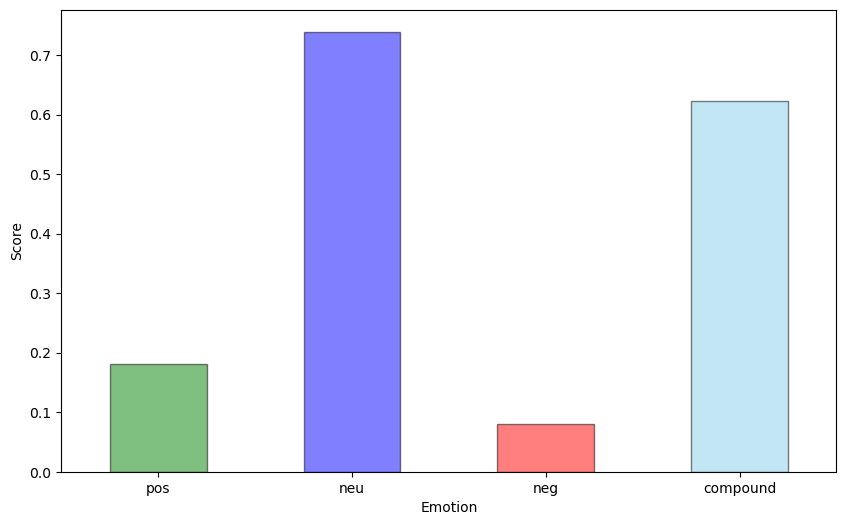

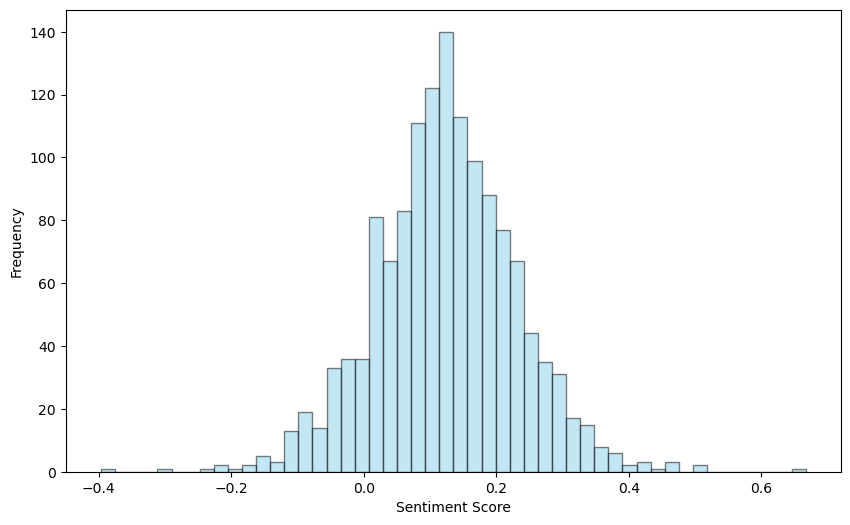

GPT-4-Turbo Sentiment Normality Test: ShapiroResult(statistic=0.9921498788271187, pvalue=9.966406183692414e-07)


In [8]:


############ 6. Sentiment Analysis and Emotion Detection ############

# Function to perform sentiment analysis


def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Function to perform emotion detection


def detect_emotions(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

# Adding sentiment analysis and emotion detection to the evaluation


def evaluate_responses_with_sentiment(data):
    # Perform sentiment analysis
    data['sentiment'] = data['generated_response'].apply(
        lambda x: analyze_sentiment(x))

    # Perform emotion detection
    emotion_scores = data['generated_response'].apply(
        lambda x: detect_emotions(x))
    data = pd.concat([data, emotion_scores.apply(pd.Series)], axis=1)

    return data


# Apply the extended evaluation function
evaluated_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/generated_responses.csv')
evaluated_data_with_sentiment = evaluate_responses_with_sentiment(
    evaluated_data)

# Display some sentiment and emotion analysis results
print(evaluated_data_with_sentiment[[
      'generated_response', 'sentiment', 'pos', 'neu', 'neg', 'compound']].head())

############ 7. Summarize Sentiment and Emotion Scores ############

# Calculate overall sentiment score
overall_sentiment = evaluated_data_with_sentiment['sentiment'].mean()
print(f"Overall Sentiment Score: {overall_sentiment}")

# Calculate average emotion scores
average_emotions = evaluated_data_with_sentiment[[
    'pos', 'neu', 'neg', 'compound']].mean()
print(f"Average Emotion Scores:\n{average_emotions}")

# Plotting the emotion distributions
plt.figure(figsize=(10, 6))
average_emotions.plot(kind='bar', color=[
                      'green', 'blue', 'red', 'skyblue'], edgecolor='black', alpha=0.5)
plt.title('Average Emotion Scores')
plt.ylabel('Score')
plt.xlabel('Emotion')
plt.xticks(rotation=0)
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/gpt_4_turbo_emotion_scores.png', dpi=600)
plt.show()

############ 8. Plot Histogram of Sentiment Scores ############

# Plot the histogram of sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data_with_sentiment['sentiment'],
         bins=50, color='skyblue', edgecolor='black', alpha=0.5)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/gpt_4_turbo_sentiment_score_distribution.png', dpi=600)
plt.show()



# Perform the Shapiro-Wilk test for normality on GPT-4-Turbo sentiment scores
gpt4turbo_normality_test = stats.shapiro(evaluated_data_with_sentiment['sentiment'])
print(f"GPT-4-Turbo Sentiment Normality Test: {gpt4turbo_normality_test}")

# GPT-4-Turbo sentiment scores are in 'evaluated_data_with_sentiment' and Save to a file sentiment scores
gpt4_mannwhiteney_sentiment = evaluated_data_with_sentiment['sentiment']  
gpt4_mannwhiteney_sentiment.to_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/GPT-4-TurboSentimentMann-Whitney.csv', index=False)


**Comparision of emotion scores with reference text**


In [ ]:
############ 6. Sentiment Analysis and Emotion Detection ############

# Function to perform sentiment analysis
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Function to perform emotion detection
def detect_emotions(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

# Adding sentiment analysis and emotion detection to the evaluation
def evaluate_responses_with_sentiment(data):
    # Perform sentiment analysis on both columns
    data['generated_sentiment'] = data['generated_response'].apply(analyze_sentiment)
    data['response_sentiment'] = data['response'].apply(analyze_sentiment)

    # Perform emotion detection on both columns
    generated_emotion_scores = data['generated_response'].apply(detect_emotions).apply(pd.Series)
    response_emotion_scores = data['response'].apply(detect_emotions).apply(pd.Series)

    # Concatenate emotion scores to the original data with prefixes
    data = pd.concat([data, generated_emotion_scores.add_prefix('generated_'), response_emotion_scores.add_prefix('response_')], axis=1)
    return data

# Apply the extended evaluation function
evaluated_data = pd.read_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/generated_responses.csv')
evaluated_data_with_sentiment = evaluate_responses_with_sentiment(evaluated_data)

# Display some sentiment and emotion analysis results
print(evaluated_data_with_sentiment.head())

############ 7. Plot Histogram of Sentiment Scores ############

# Plot the histogram of sentiment scores for generated responses
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data_with_sentiment['generated_sentiment'],
         bins=50, color='skyblue', edgecolor='black', alpha=0.5)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Generated Responses')
plt.show()

############ 8. Plot Grouped Emotion Scores ############

# Calculate average emotion scores
average_generated_emotions = evaluated_data_with_sentiment[['generated_pos', 'generated_neu', 'generated_neg', 'generated_compound']].mean()
average_response_emotions = evaluated_data_with_sentiment[['response_pos', 'response_neu', 'response_neg', 'response_compound']].mean()

# Creating indices for grouped bar chart
index = np.arange(len(average_generated_emotions))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(index, average_generated_emotions, bar_width, label='Generated', color='orange', alpha=0.8)
plt.bar(index + bar_width, average_response_emotions, bar_width, label='Reference', color='blue', alpha=0.8)

plt.xlabel('Emotion')
plt.ylabel('Scores')
#plt.title('Comparison of Emotion Scores between Generated and Response')
plt.xticks(index + bar_width / 2, ('Positive', 'Neutral', 'Negative', 'Compound'))
plt.legend()
plt.tight_layout()
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/gpt_4_turbo_emotion_scores_comparision.eps', dpi=600)
plt.show()

**Read the sentiment scores of GPT-4 Turbo and GPT-4 from the saved CSV files and compare them**


In [9]:

# Load sentiment scores from the CSV files
gpt4_sentiment = pd.read_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/GPT-4-SentimentMann-Whitney.csv')
gpt4turbo_sentiment = pd.read_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/GPT-4-TurboSentimentMann-Whitney.csv')

# Perform the Mann-Whitney U test to compare the two
stat, p_value = stats.mannwhitneyu(gpt4_sentiment, gpt4turbo_sentiment)

# Print the result
print(f"U-statistic: {stat}, p-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between GPT-4 and GPT-4-Turbo sentiment scores.")
else:
    print("There is no statistically significant difference between GPT-4 and GPT-4-Turbo sentiment scores.")


U-statistic: [611592.], p-value: [5.74801037e-61]
There is a statistically significant difference between GPT-4 and GPT-4-Turbo sentiment scores.
